Notebook for model optimisation 

In [173]:
! pip install -q tensorflow-model-optimization

In [174]:
#set the channel number here
channel = 27

In [175]:
#allow file access
from google.colab import files

from tensorflow.keras.models import load_model

import pickle

#import shap  
#import shap
#shap.initjs()

import pandas as pd
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior() #this was required for SHAP values
#possibly worth using the below 
#tf.compat.v1.enable_eager_executionconfig=None, device_policy=None, execution_mode=None)
from tensorflow import keras


#borrowed form 5c16
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

from keras.models import model_from_json


from tensorflow.keras.callbacks import CSVLogger

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

#r2 score
#from keras import backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import r2_score

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

#model optimisation api
import tensorflow_model_optimization as tfmot

import tempfile
import os
import zipfile

%load_ext tensorboard

from tabulate import tabulate

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [176]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.metrics = []
        self.val_metrics = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('r_squared'))
        self.val_acc.append(logs.get('val_r_squared'))
        ###
        self.metrics.append(logs.get('mean_absolute_percentage_error'))         #mean_squared_error
        self.val_metrics.append(logs.get('val_mean_absolute_percentage_error')) #val_mean_squared_error
        
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(60, 20))
        plt.plot([3, 1])

        #plot 1 mean absolute percentage error
        plt.subplot(131) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('Mse')
        plt.xlabel('epoch')
        plt.title('MSE Value')
        plt.legend()

        #plot 2 r squared value
        plt.subplot(133)         
        plt.plot(self.x, self.acc, label="training r-squared")
        plt.plot(self.x, self.val_acc, label="validation r-squared")
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('R-squared')
        plt.xlabel('epoch')
        plt.title('R-Squared Value')

        #plot 3 mean squared error
        plt.subplot(132)         
        plt.plot(self.x, self.metrics, label="training mse")
        plt.plot(self.x, self.val_metrics, label="validation mse")
        plt.legend()
        plt.ylabel('Mean absolute percentage Error')
        plt.xlabel('epoch')
        plt.title('Mean absolute percentage Error')
        
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
        

#creating a r^2 metric for the model evaluation
def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

    

In [177]:
ch_names = np.arange(44).tolist()
freqs = np.arange(191.6, 195.9, 0.1).tolist()
for x in range(len(ch_names)):
  ch_names[x] = "Ch %.0f (%.1f)" % (ch_names[x], freqs[x])

In [178]:
#generate the train and validation datasets
#retreiving both datasets from GitHub
git_xval = 'https://raw.githubusercontent.com/p-owens/MAI/main/x_val.csv'
git_yval = 'https://raw.githubusercontent.com/p-owens/MAI/main/y_val.csv'
df_x = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names)

df_y = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names)

#dropping the frequences row for each training sample
df_x = df_x.iloc[1::2]
#print(df_x)

In [179]:
#drop all rows where df_x has a value != 0
df_chx = df_x[df_x[ch_names[channel]] !=0].iloc[500:,:]
df_chy = df_y[df_y[ch_names[channel]] !=0].iloc[500:,:]
df_chy = df_chy[ch_names[channel]]

#convert to numpy arrays
x_values = df_chx.to_numpy()
y_values = df_chy.to_numpy()

#adding some samples where the channel is 0
#x values
df_xzero = df_x.iloc[:500,:]
x_values = np.concatenate((x_values, df_xzero.to_numpy()), axis=0)

#y values
df_yzero = df_y.iloc[:500,channel]
y_values = np.concatenate((y_values, df_yzero.to_numpy()), axis=0)


#generate the test/validation split
val_split = .2
x_train, x_val, y_train, y_val = skl.model_selection.train_test_split(x_values, y_values, test_size = val_split, random_state = 0)#renaimed x_rem and y_rem to x_values and y_values


In [180]:
print(x_values.shape[0])

6266


In [181]:
#Using a dataset with 1 ch constantly on for the test set
#retreiving both datasets from GitHub



git_xval = ('https://raw.githubusercontent.com/p-owens/MAI/main/const_ch/ch{0}/x_val.csv'.format(channel))
git_yval = ('https://raw.githubusercontent.com/p-owens/MAI/main/const_ch/ch{0}/y_val.csv'.format(channel))
dfx = pd.read_csv(git_xval,
                  index_col=False,
                  header=None,
                  names=ch_names                                   
                 )
dfy = pd.read_csv(git_yval,
                  index_col=False,
                  header=None,
                  names=ch_names
                 )

#dropping the frequences row for each training sample
dfx = dfx.iloc[1::2]

#drop all rows where df_x has a value != 0
dfx = dfx[dfx[ch_names[channel]] !=0]
dfy = dfy[dfy[ch_names[channel]] !=0]
dfy = dfy[ch_names[channel]]

x_test = dfx.to_numpy()
y_test = dfy.to_numpy()

In [182]:
#loading a previously saved model

model_dir = "ch_27_ep_750_pct_err_3.7_mse_0.0_.h5"

l_rate = 1 * 1e-4
opt = tf.keras.optimizers.Nadam(learning_rate=l_rate)

model = tf.keras.models.load_model(model_dir, custom_objects={'r_squared': r_squared})
model.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])

model.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 360)               16200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 360)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 180)               64980     
_________________________________________________________________
dropout_41 (Dropout)         (None, 180)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 180)               32580     
_________________________________________________________________
dropout_42 (Dropout)         (None, 180)               0   

In [183]:
#evaluating the loaded model


results = model.evaluate(x_test,y_test)#, verbose=1)
print("{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {percent_err:<.3%}\t(lower is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[2],
                                                                                                    mse = results[0],
                                                                                                    percent_err = results[2]/100))
_, keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model, keras_file, include_optimizer=False)
print('Saved baseline model to:', keras_file)




25/25 [==============================] - 0s 2ms/step - loss: 0.0243 - r_squared: 0.9033 - mean_absolute_percentage_error: 3.9617
loss		: 0.0200	(lower is better)
mean_absolute_percentage_error	: 3.624%	(lower is better)
Saved baseline model to: /tmp/tmpj4x_z19e.h5


In [201]:

layer_names = []

for layer in model.layers:
  if isinstance(layer, tf.keras.layers.Dense):
    layer_names.append(layer.name)


pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.975,
                                                               begin_step=0,
                                                               end_step=end_step)}  

epochs_prune = 250
batch_size = 400

#validation_split = val_size # 10% of training set will be used for validation set. 
num_images = x_test.shape[0] * (1 - val_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs_prune                                                                                                                         


def apply_pruning_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    if (layer.name in layer_names[1:-1]):
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
  return layer


model_for_pruning = tf.keras.models.clone_model(
    model,
    clone_function=apply_pruning_to_dense)

model_for_pruning.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=l_rate / 2),
              loss='mean_squared_error',
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])

model_for_pruning.summary()


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_48 (Dense)             (None, 360)               16200     
_________________________________________________________________
dropout_40 (Dropout)         (None, 360)               0         
_________________________________________________________________
prune_low_magnitude_dense_49 (None, 180)               129782    
_________________________________________________________________
dropout_41 (Dropout)         (None, 180)               0         
_________________________________________________________________
prune_low_magnitude_dense_50 (None, 180)               64982     
_________________________________________________________________
dropout_42 (Dropout)         (None, 180)               0   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [202]:
"""
#pruning the model

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

epochs_prune = 250
batch_size = 400
#validation_split = val_size # 10% of training set will be used for validation set. 

num_images = x_test.shape[0] * (1 - val_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs_prune


"""          
#pruning_params = {'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.95,
#                                                                            begin_step=0,
#                                                                            end_step = end_step)}
"""                                                                            

# Define model for pruning - polynomial decay.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)}                                                            
                                                     

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=l_rate / 2),
              loss='mean_squared_error',
              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])

model_for_pruning.summary()
"""

"                                                                            \n\n# Define model for pruning - polynomial decay.\npruning_params = {\n      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0,\n                                                               final_sparsity=0.80,\n                                                               begin_step=0,\n                                                               end_step=end_step)}                                                            \n                                                     \n\nmodel_for_pruning = prune_low_magnitude(model, **pruning_params)\n\n# `prune_low_magnitude` requires a recompile.\nmodel_for_pruning.compile(optimizer = tf.keras.optimizers.Nadam(learning_rate=l_rate / 2),\n              loss='mean_squared_error',\n              metrics=[r_squared, tf.keras.metrics.MeanAbsolutePercentageError()])\n\nmodel_for_pruning.summary()\n"

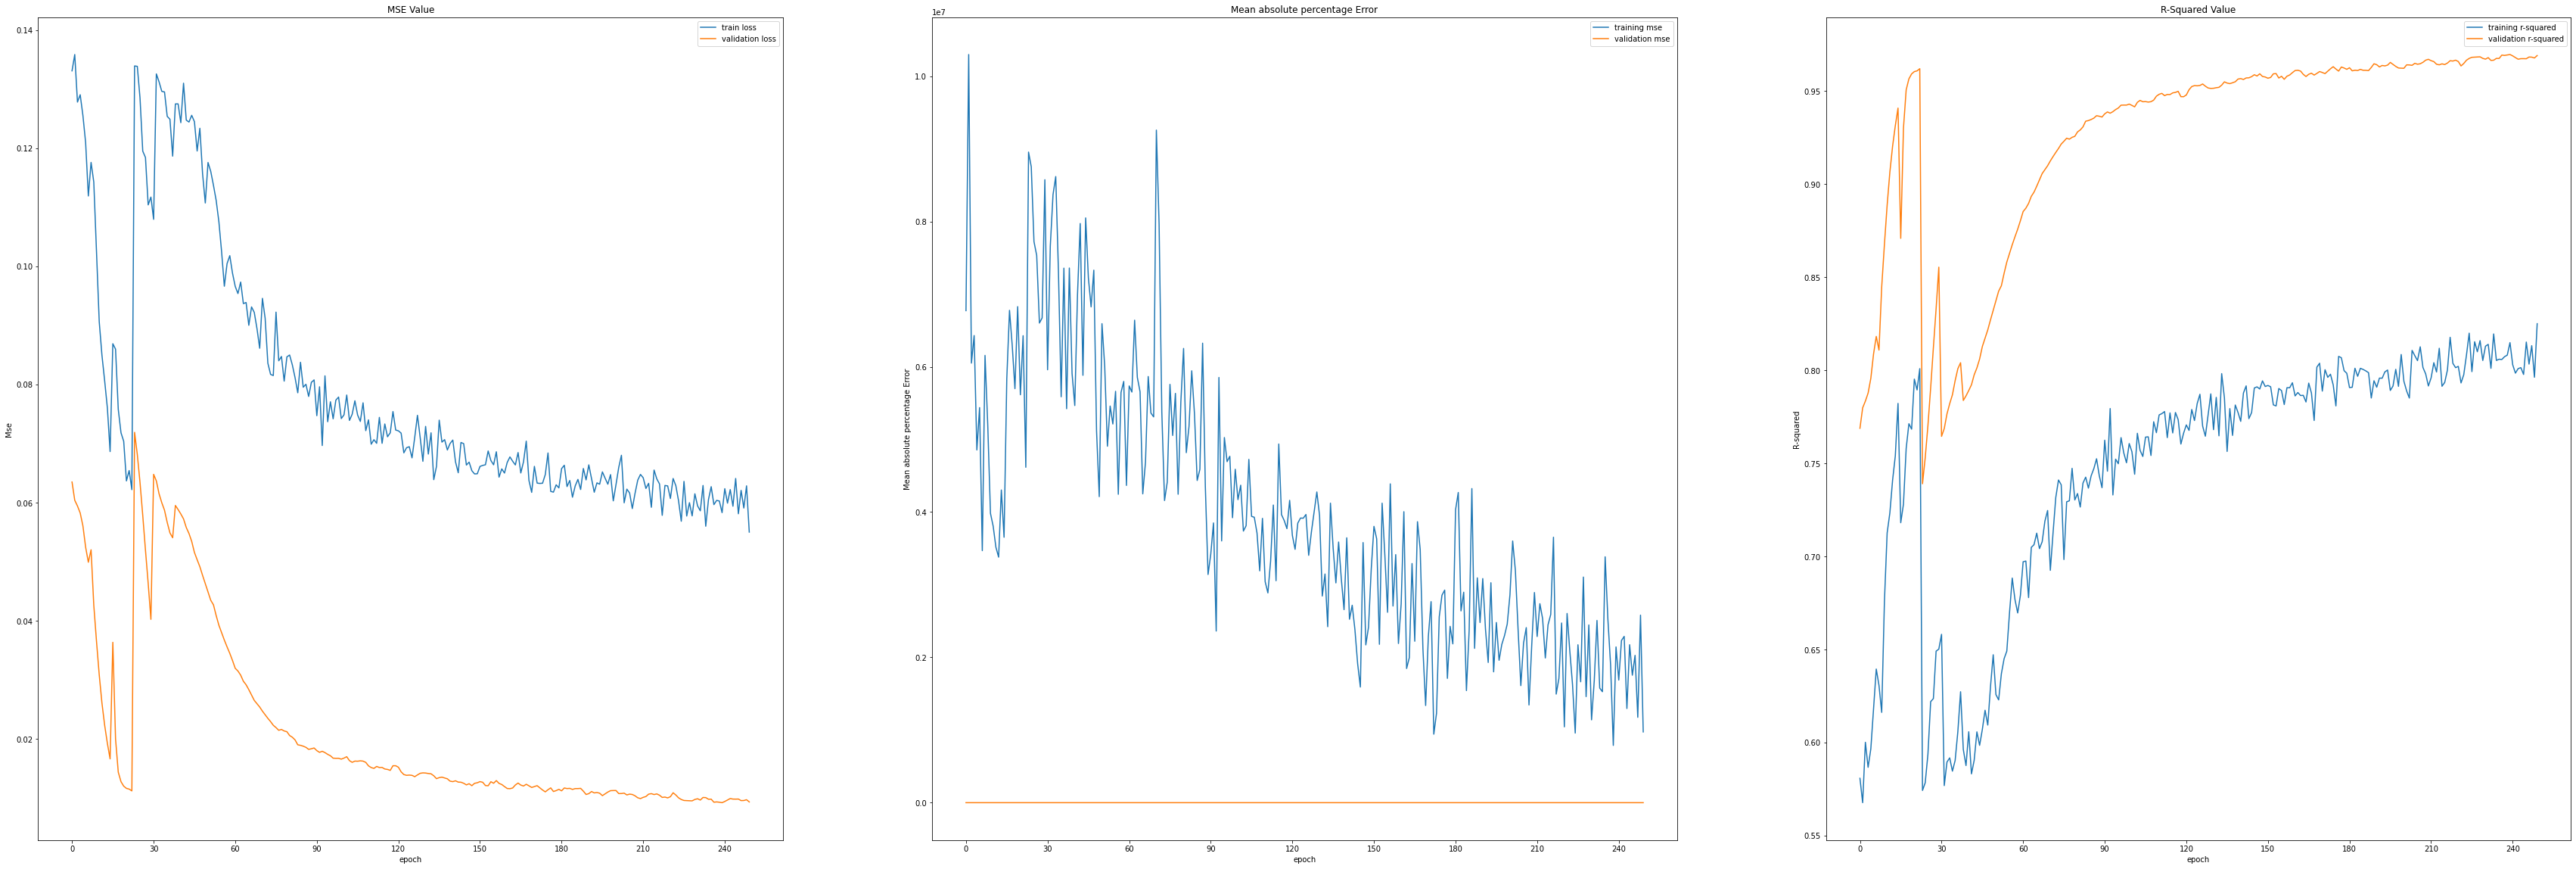

In [203]:
logdir = tempfile.mkdtemp()
log_file = "model_ch_{0}.csv".format(channel)
csv_log = CSVLogger(log_file)
pltCallBack = PlotLossAccuracy()

callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
             tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
             pltCallBack,
             csv_log]
  
model_for_pruning.fit(x_train,
                      y_train,
                      batch_size=batch_size,
                      verbose=1,
                      epochs=epochs_prune, 
                      validation_data=(x_val, y_val), 
                      callbacks=callbacks)

In [204]:
#print the logfile of the model training data
pd.read_csv(log_file, index_col='epoch')

,loss,mean_absolute_percentage_error,r_squared,val_loss,val_mean_absolute_percentage_error,val_r_squared
epoch,,,,,,
0,0.133093,6.772254e+06,0.580774,0.063487,5.640351,0.768784
1,0.135859,1.029812e+07,0.567672,0.060396,4.945782,0.779788
2,0.127804,6.050188e+06,0.600108,0.059424,5.077075,0.783395
3,0.129048,6.430186e+06,0.586671,0.058245,5.081284,0.787713
4,0.125544,4.854980e+06,0.596564,0.056066,4.790065,0.795603
...,...,...,...,...,...,...
245,0.058107,1.754186e+06,0.815121,0.009811,2.641293,0.967325
246,0.062068,2.027891e+06,0.803278,0.009549,2.607116,0.968236
247,0.059077,1.174602e+06,0.813179,0.009564,2.637293,0.968175


In [219]:
#Compare pruned model v unpruned model

results_pruned = model_for_pruning.evaluate(x_test,y_test, verbose=1)
print("Baseline Model:\n{name1}\t\t: {mse:<.4f}\t(lower is better)\n{name2}\t: {r2:<.2%}\t(higher is better)".format(name1 = model.metrics_names[0],
                                                                                                    name2 = model.metrics_names[2],
                                                                                                    mse = results[0],
                                                                                                    r2 = results[2]/100))

print("Pruned Model:\n{namep1}\t\t: {pmse:<.4f}\t(lower is better)\n{namep2}\t: {pr2:<.2%}\t(higher is better)".format(namep1 = model_for_pruning.metrics_names[0],
                                                                                                    namep2 = model_for_pruning.metrics_names[2],
                                                                                                    pmse = results_pruned[0],
                                                                                                    pr2 = results_pruned[2]/100))

25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - r_squared: 0.8780 - mean_absolute_percentage_error: 4.3327
Baseline Model:
loss		: 0.0200	(lower is better)
mean_absolute_percentage_error	: 3.62%	(higher is better)
Pruned Model:
loss		: 0.0306	(lower is better)
mean_absolute_percentage_error	: 4.33%	(higher is better)


In [206]:
#docs_infra: no_execute
#%tensorboard --logdir={logdir}

In [207]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /tmp/tmpqh8ynoe9.h5


In [208]:
headings = ["Layer Name", "Total Parameters", "% Zero"]
format_row = "{:<50}" * (len(headings) + 1)

values = []

for i, w in enumerate(model_for_export.get_weights()):
    if(w.size > 1 and (np.sum(w == 0) != 0)):
      inner_list = []
      inner_list.append("{}".format({model_for_export.weights[i].name}))
      inner_list.append("{}".format(w.size))
      inner_list.append("{:.2f}%".format(np.sum(w == 0) / w.size * 100))
      values.append(inner_list)

print (tabulate(values, headings, numalign='left', tablefmt='rst'))

=====================  ==================  ========
Layer Name             Total Parameters    % Zero
=====================  ==================  ========
{'dense_49/kernel:0'}  64800               97.50%
{'dense_50/kernel:0'}  32400               97.50%
{'dense_51/kernel:0'}  16200               97.50%
{'dense_52/kernel:0'}  4050                97.51%
=====================  ==================  ========


In [216]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

_, pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(pruned_tflite_file, 'wb') as f:
  f.write(pruned_tflite_model)

print('Saved pruned TFLite model to:', pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpgxghrzmt/assets


INFO:tensorflow:Assets written to: /tmp/tmpgxghrzmt/assets


Saved pruned TFLite model to: /tmp/tmpi5icdq_4.tflite


In [217]:
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


In [212]:
#creating a quantised tf lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_and_pruned_tflite_model = converter.convert()

_, quantized_and_pruned_tflite_file = tempfile.mkstemp('.tflite')

with open(quantized_and_pruned_tflite_file, 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

print('Saved quantized and pruned TFLite model to:', quantized_and_pruned_tflite_file)

INFO:tensorflow:Assets written to: /tmp/tmpzmibucan/assets


INFO:tensorflow:Assets written to: /tmp/tmpzmibucan/assets


Saved quantized and pruned TFLite model to: /tmp/tmpm51txayy.tflite


In [294]:
orig = get_gzipped_model_size(keras_file)
reduced = get_gzipped_model_size(pruned_keras_file)
tf_lite = get_gzipped_model_size(pruned_tflite_file)
tfl_quantized = get_gzipped_model_size(quantized_and_pruned_tflite_file)


headings = ["Model", "Size (bytes)", "Compression (%)"]
values = []
values.append(["Keras - Baseline", "{:,d}".format(orig), "{:.1%}".format(1 - orig/orig)]) #origional = 
values.append(["Keras - Pruned", "{:,d}".format(reduced), "{:.1%}".format(1 - reduced/orig)]) #pruned = 
values.append(["TFlite - Pruned", "{:,d}".format(tf_lite), "{:.1%}".format(1 - tf_lite/orig)])    #tlf = 
values.append(["TFlite - Pruned & Quantized", "{:,d}".format(tfl_quantized), "{:.1%}".format(1 - tfl_quantized/orig)])  #tfl_q = 

print (tabulate(values, headings, numalign='left', tablefmt='rst'))

===========================  ==============  =================
Model                        Size (bytes)    Compression (%)
===========================  ==============  =================
Keras - Baseline             497,621         0.0%
Keras - Pruned               114,260         77.0%
TFlite - Pruned              112,142         77.5%
TFlite - Pruned & Quantized  26,230          94.7%
===========================  ==============  =================


In [296]:
#function to evaluate the tflight model
def eval_tf_lite(interpreter):

  interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
  interpreter.allocate_tensors()

  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on ever y image in the "test" dataset.
  y_pred = []
  for test in (x_test):
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test = np.expand_dims(test, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test)

    # Run inference.
    interpreter.invoke()

    prediction = interpreter.get_tensor(output_details[0]['index'])[0][0]
    y_pred.append(prediction)

  #return mean absolute percentage error
  y_pred = np.array(y_pred)
  mse = tf.keras.losses.MeanAbsolutePercentageError()                                 #tf.keras.losses.MeanSquaredError()
  return mse(y_test, y_pred).numpy()

In [297]:
test_accuracy = eval_tf_lite(quantized_and_pruned_tflite_model)
print(test_accuracy)

4.327798
